In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import os

In [2]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want tof use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    rX1 = 0
    rX2 = 0
    rY1 = 0
    rY2 =0
    rCount = 0
    rSlope = 0
    
    lX1 = 0
    lX2 = 0
    lY1 = 0
    lY2 =0
    lCount = 0
    lSlope = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if slope > 0.25:
                rX1 += x1
                rX2 += x2
                rY1 += y1
                rY2 += y2
                rCount += 1
                #print ('rslope = ', slope)
                rSlope += slope    
            if slope < -0.25:
                lX1 += x1
                lX2 += x2
                
                lY1 += y1
                lY2 += y2
                lCount += 1
                lSlope += slope
                
    rX1 = int(rX1/rCount)
    rY1 = int(rY1/rCount)
    rX2 = int(rX2/rCount)
    rY2 = int(rY2/rCount) 
    print (rX1, rY1, ', ', rX2, rY2)
    #print ('rslope avg : -> ', rSlope/rCount)
    
    rSlope = (rY2-rY1)/(rX2-rX1)
    #print ('rslope cal : -> ', rSlope)
    
    
    rBottomX = int( rX1+ ((540-rY1)/rSlope)  )
    rTopX = int(  rX1+ ((302-rY1)/rSlope)  )
    
    print("right BottomX -> " , rBottomX, 540, ",", rX1, rY1)
    
    cv2.line(img, (rBottomX, 540), (rTopX, 302), color, thickness)  
    cv2.line(img, (rX1, rY1), (rX2, rY2), color, thickness)  
    #print ('bottom point -> ',  rBottomX ,', 540' , '  top point -> ', rTopX, ', 302 ' )

    lX1 = int(lX1/lCount)
    lY1 = int(lY1/lCount)
    lX2 = int(lX2/lCount)
    lY2 = int(lY2/lCount)
    lSlope = (lY2-lY1)/(lX2-lX1)
    
    lBottomX = int(( lX1 + (540-lY1)/lSlope)  )
    lTopX = int( (lX1+(302-lY1)/lSlope))
    #print (lBottomX , 540)
        
    cv2.line(img, (lTopX, 302), (lBottomX, 540), color, thickness)  
    #cv2.line(img, (lX1, lY1), (lX2, lY2), color, thickness)  

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
(540, 960, 3)
( 140 ,  540 ) (480, 302) (490,302) (850,  540 )
625 400 ,  648 415
right BottomX ->  839 540 , 625 400


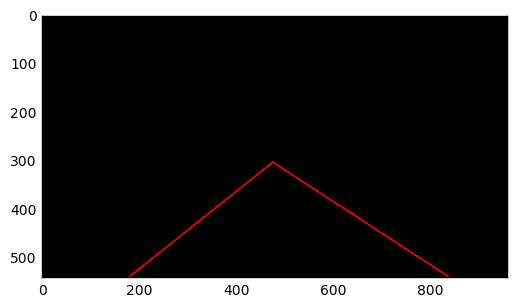

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('../exit-ramp.jpg')
color_select = np.copy(image)
gray = cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY)
print('This image is:', type(gray), 'with dimesions:', gray.shape)

blur_gray = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur_gray, 50, 150)

imshape = image.shape
print (imshape)

vertices = np.array([[(140,imshape[0]),(480, 302), (490, 302), (850,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
lines_edges = hough_lines(masked_edges, rho=1, theta=np.pi/180, threshold=1, min_line_len=5, max_line_gap=1)

#plt.figure(1)
#plt.subplot(221)
plt.imshow(lines_edges, cmap='gray')
#plt.subplot(222)
#plt.imshow(lines_edges, cmap='gray')